In [7]:
import numpy as np
from matplotlib import pyplot as plt
import sys, os
sys.path.insert(1, '../quantarhei')
sys.path.insert(2, '../spectre')
import quantarhei as qr
import spectre
import spectre.full as sef
import spectre.spectroscopy.abs_spectroscopy as abss

# (1.) - step 2

In [8]:
path = 'C:/Users/micha/Documents/Studium/MScThesis/data-meta/E-scanopt-ether02-1mode/results_E-ether02-1mode-11010_scanopt_01_2023-07-01_14-14-11/'

In [9]:
files = [file for file in os.listdir(path) if file.endswith('.json') and file.startswith('opt')]
sfiles = sorted(files, key=lambda s: float(s.split('.')[0].split('_')[2]))

C:\Users\micha\AppData\Local\Temp\ipykernel_14232\4220604495.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))
C:\Users\micha\AppData\Local\Temp\ipykernel_14232\4220604495.py:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='horizontal')


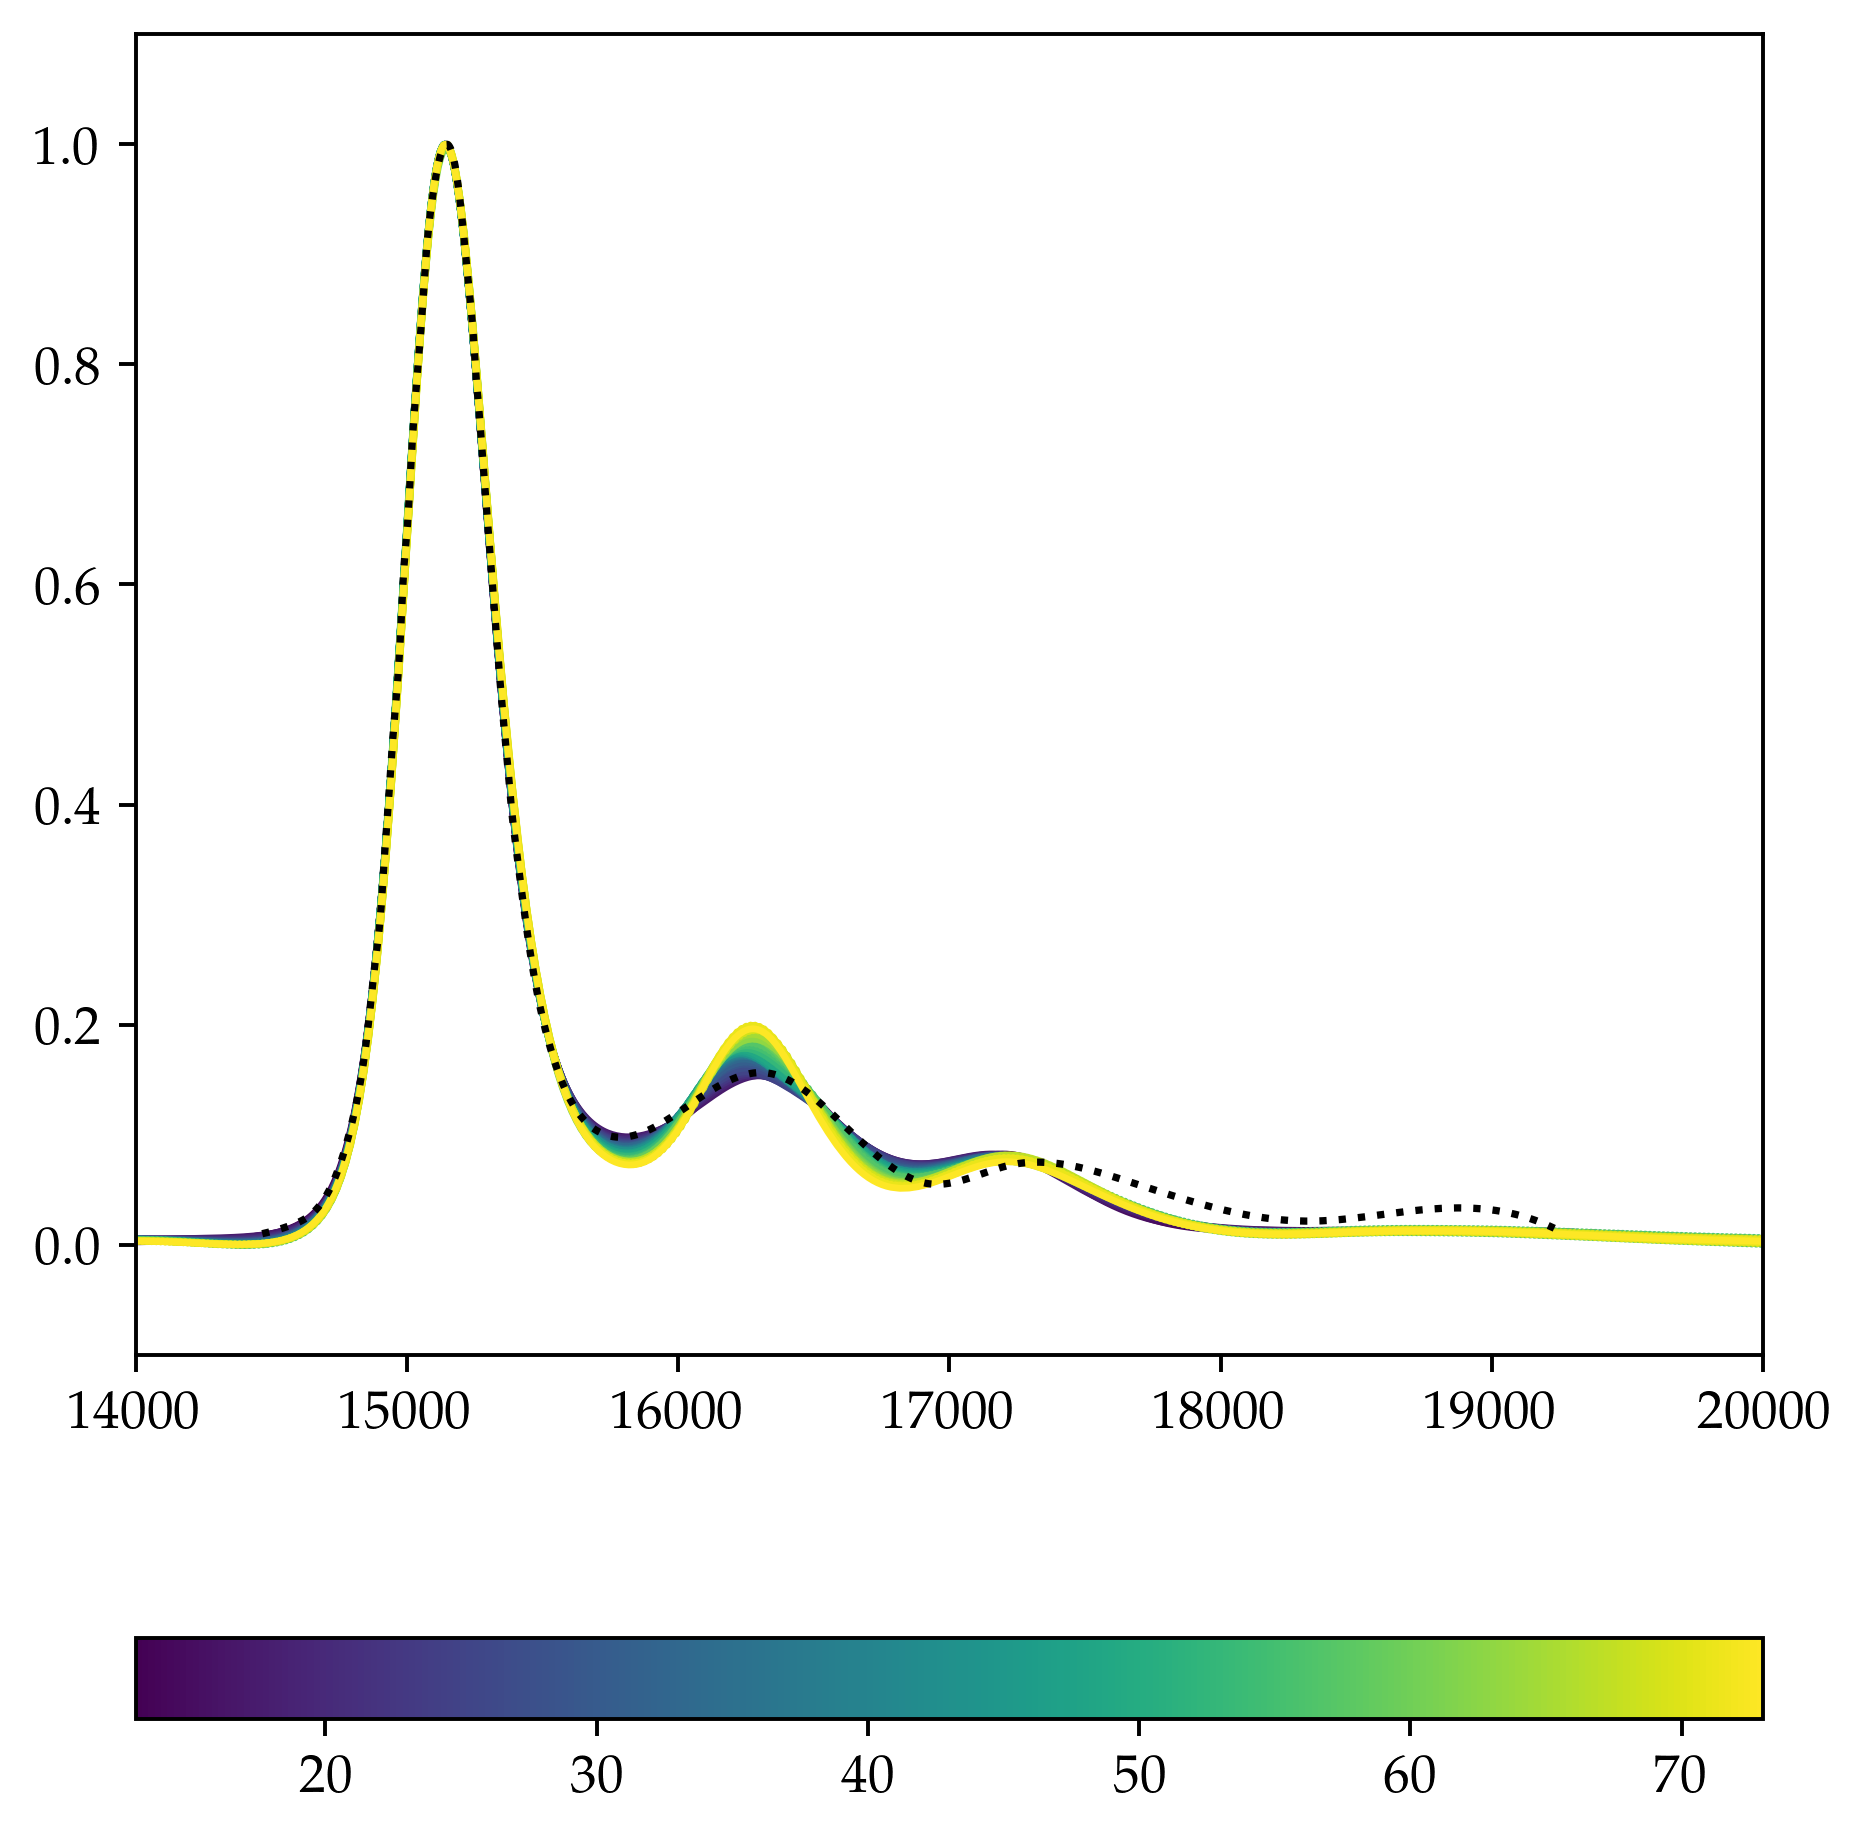

In [10]:
from matplotlib import cm
clm = cm.get_cmap('viridis', len(files))

fig, ax = plt.subplots(figsize=(6,7), dpi= 350)
labels = list()

for i, f in enumerate(sfiles[:]):
    filepath = os.path.join(path, f)
    optpars = spectre.utils.loadjson(filepath)
    datapath = filepath.replace('.json', '.npy')
    
    if os.path.isfile(datapath):
        data = np.load(datapath)
    else:
        syst, ta = spectre.full.init_system(optpars)
        spec = abss.calculate_abs_spectrum(syst, ta, optpars)
        spec.normalize()
        
        with qr.energy_units('1/cm'):
            data = np.vstack([spec.axis.data, spec.data])
            np.save(datapath, data)

    lab = f.split('.')[0].split('_')[2]
    plt.plot(data[0], data[1], label=lab, linewidth=1.4, color=clm(i))
    labels.append(lab)

plt.xlim(14000, 20000)
plt.ylim(-0.1, 1.1)
#plt.legend(frameon=False)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(labels[0], labels[-1]))
cbar = plt.colorbar(sm, orientation='horizontal')
#cbar.set_ticklabels(labs)

abss.plot_ref(2, plot_to=ax, color='k', linestyle = 'dotted')

C:\Users\micha\AppData\Local\Temp\ipykernel_14232\836523726.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))
C:\Users\micha\AppData\Local\Temp\ipykernel_14232\836523726.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[3])


Text(0, 0.5, 'residuum')

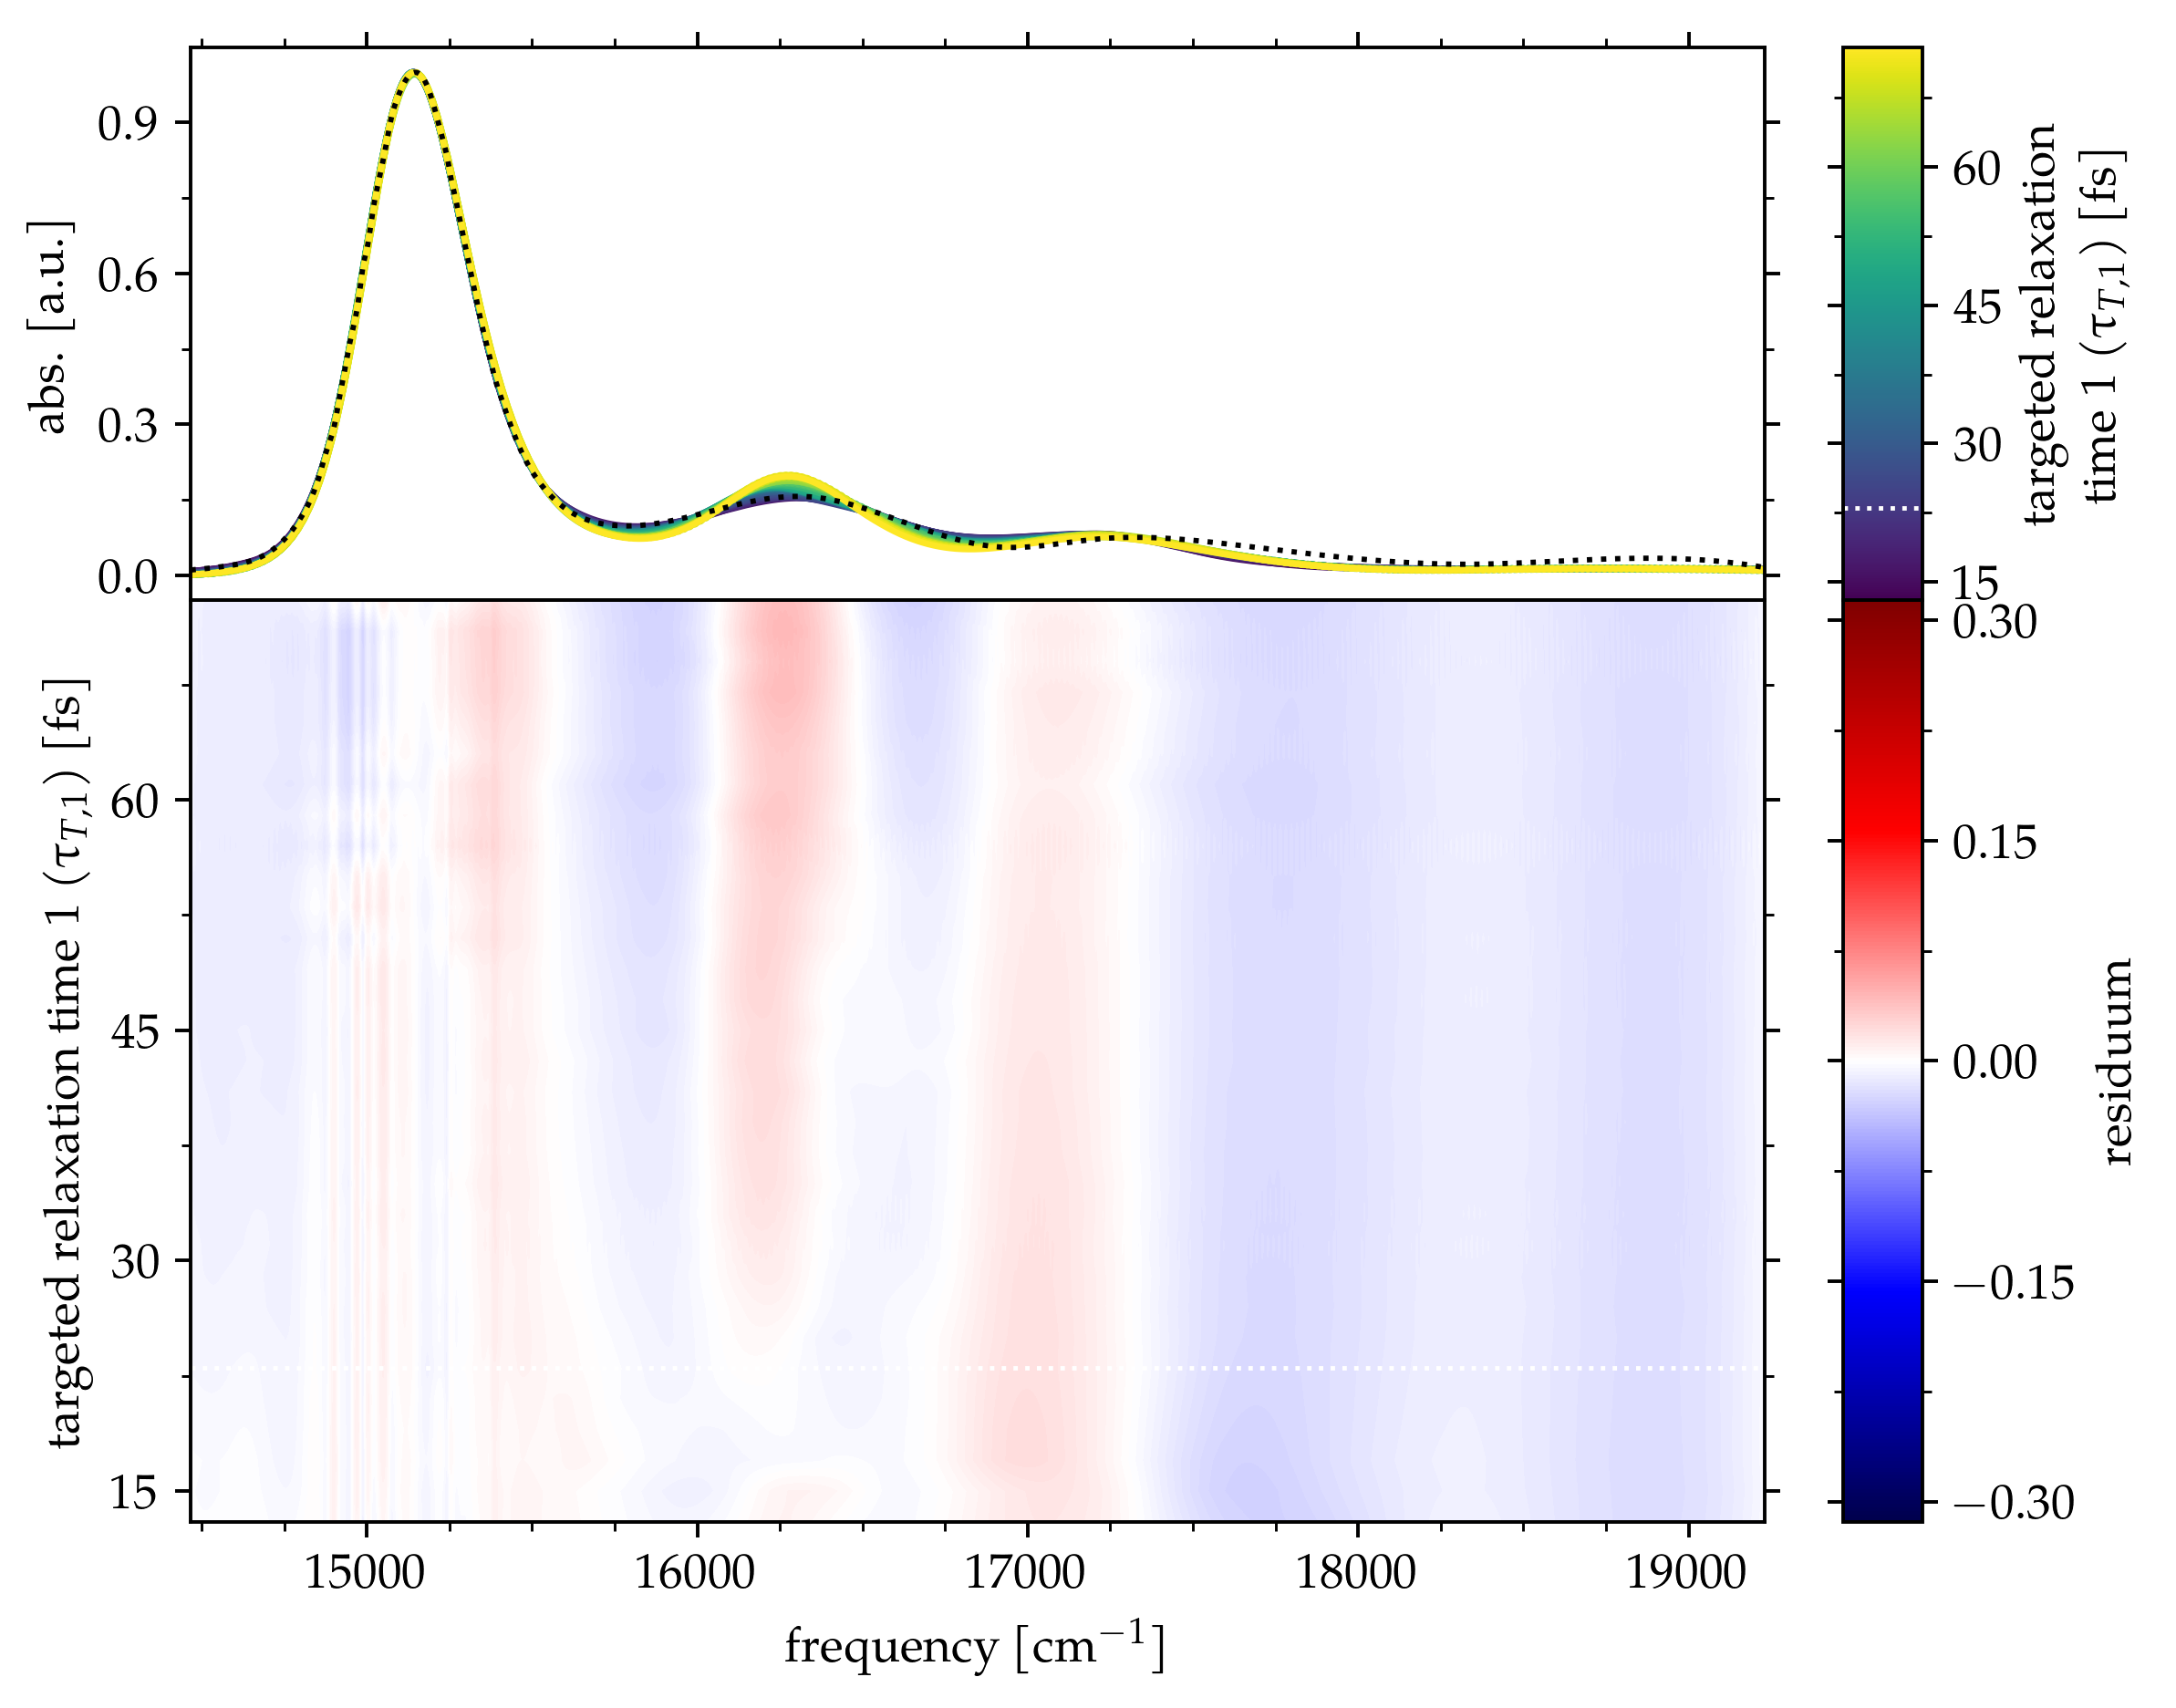

In [11]:
from matplotlib import cm
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
from matplotlib import gridspec

spline_s=0.0002
spline_k=3

clm = cm.get_cmap('viridis', len(files))

refdata = abss.plot_ref(2, return_data='data', plot=False)
refx, refy = refdata

fig, ax = plt.subplots(num=None, figsize=(7,6), dpi=350, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 0.05, 0.05), height_ratios=(0.6, 1), figure=fig) 
#ax3 = plt.subplot(gs[3])
ax0 = plt.subplot(gs[3])
ax1 = plt.subplot(gs[0], sharex = ax0)
ax4 = plt.subplot(gs[5])
ax2 = plt.subplot(gs[2])
plt.subplots_adjust(hspace=0, wspace=0)

####################
#   ax1   #  # ax2 #
####################
#   ax0   #  # ax4 #
####################

all_data_filename = 'all_data.npy'
all_data_path = os.path.join(path, all_data_filename)

if os.path.isfile(all_data_path) and True:
    x, y, zdata = np.load(all_data_path)

    for i, z in enumerate(zdata):
        ax1.plot(x[i], z, linewidth=1.4, color=clm(i))
    
    zax = zdata - refy

else:
    labels = list()
    zax = None
    zdata = None
    i = 0

    for f in tqdm(sfiles[:]):
        i += 1
        filepath = os.path.join(path, f)
        optpars = spectre.utils.loadjson(filepath)
        datapath = filepath.replace('.json', '.npy')
        
        if os.path.isfile(datapath):
            data = np.load(datapath)
        else:
            syst, ta = spectre.full.init_system(optpars)
            spec = abss.calculate_abs_spectrum(syst, ta, optpars)
            spec.normalize()
            
            with qr.energy_units('1/cm'):
                data = np.vstack([spec.axis.data, spec.data])
                np.save(datapath, data)
    
        lab = f.split('.')[0].split('_')[2]
        spline = UnivariateSpline(*data, k=spline_k, s=spline_s)
        ydat = spline(refx) - refy
        
        if zax is None:
            zax = ydat
            zdata = spline(refx)
        else:
            zax = np.vstack([zax, ydat])
            zdata = np.vstack([zdata, spline(refx)])
        
        ax1.plot(data[0], data[1], label=lab, linewidth=1.4, color=clm(i))
        labels.append(float(lab))

    yax = np.array(labels)
    xax = refx
    x, y = np.meshgrid(xax, yax)
    np.save(all_data_path, np.array([x, y, zdata]))

maximum = np.abs(zax).max()
maximum = 0.313830306708

cf = ax0.contourf(x, y, zax, 500, cmap="seismic", vmax=maximum, vmin=-maximum)

#CS = ax0.contour(x, y, zax, 5)
#ax0.clabel(CS, inline=True, fontsize=10)

sm = plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(-maximum, maximum))
cbar = plt.colorbar(sm, cax=ax4, orientation='vertical')

sm2 = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(y[0,0], y[-1,0]))
cbar2 = plt.colorbar(sm2, cax=ax2, orientation='vertical')

ax0.plot([x[0,0], x[0,-1]], [23,23], linewidth=1, linestyle='dotted', c='w')
ax2.plot([0, 1], [23,23], linewidth=1, linestyle='dotted', c='w')

abss.plot_ref(2, plot_to=ax1, linestyle='dotted', c='k', linewidth=1.2)

from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator

for g in [ax0, ax1, ax2, ax4]:
    pars = dict(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                bottom=True,           top=True,      left=True,      right=True,)
    g.tick_params(which='both', **pars)
    
    #g.xaxis.set_major_locator(MultipleLocator(20))
    #g.xaxis.set_major_formatter('{x:.0f}')
    #g.xaxis.set_minor_locator(MultipleLocator(10))
    g.yaxis.set_major_locator(MaxNLocator(nbins=4))
    g.yaxis.set_minor_locator(AutoMinorLocator(2))
    g.xaxis.set_minor_locator(AutoMinorLocator(4))
    #g.ticklabel_format(style='sci', axis='y', scilimits=(-1,3), useOffset=True)

    #g.get_yaxis().set_offset_position("left")
    #g.get_yaxis().OFFSETTEXTPAD = 7
    #g.get_yaxis().get_offset_text().set_position((-0.097,0))

ax4.yaxis.set_major_locator(MaxNLocator(nbins=5))

ax0.tick_params(which='both', labelbottom=True, labelleft=True)
ax1.tick_params(which='both', bottom=False)
ax2.tick_params(which='both', labelleft=False, labelright=True)
ax4.tick_params(which='both', labelleft=False, labelright=True)

ax0.set_xlim(x[0,0], x[0,-1])
ax1.set_ylim(-0.05, 1.05)

ax0.set_xlabel(r'frequency [cm$^{-1}$]')
#ax0.set_ylabel(r'vibrational relaxation time 1 (VRT1) [fs]')
ax0.set_ylabel(r'targeted relaxation time 1 ($\uptau_{T,1}$) [fs]')
ax1.set_ylabel(r'abs. [a.u.]')
ax2.set_ylabel(r'\parbox{40mm}{\centering targeted relaxation time 1 ($\uptau_{T,1}$) [fs]}')
ax4.set_ylabel(r'residuum')

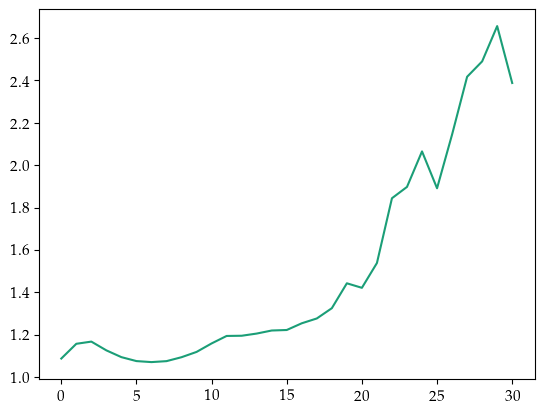

In [33]:
plt.plot((zax**2).sum(axis=1))

In [16]:
def draw_line(plot_to, xaxis, *vals, **pars):
    for val in vals:
        plot_to.plot([xaxis[0]-10, xaxis[-1]+10], [val, val], **pars)

C:\Users\micha\AppData\Local\Temp\ipykernel_13460\2872996659.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))


Text(0.5, 0, 'vibrational relaxation time 1 (VRT1) [fs]')

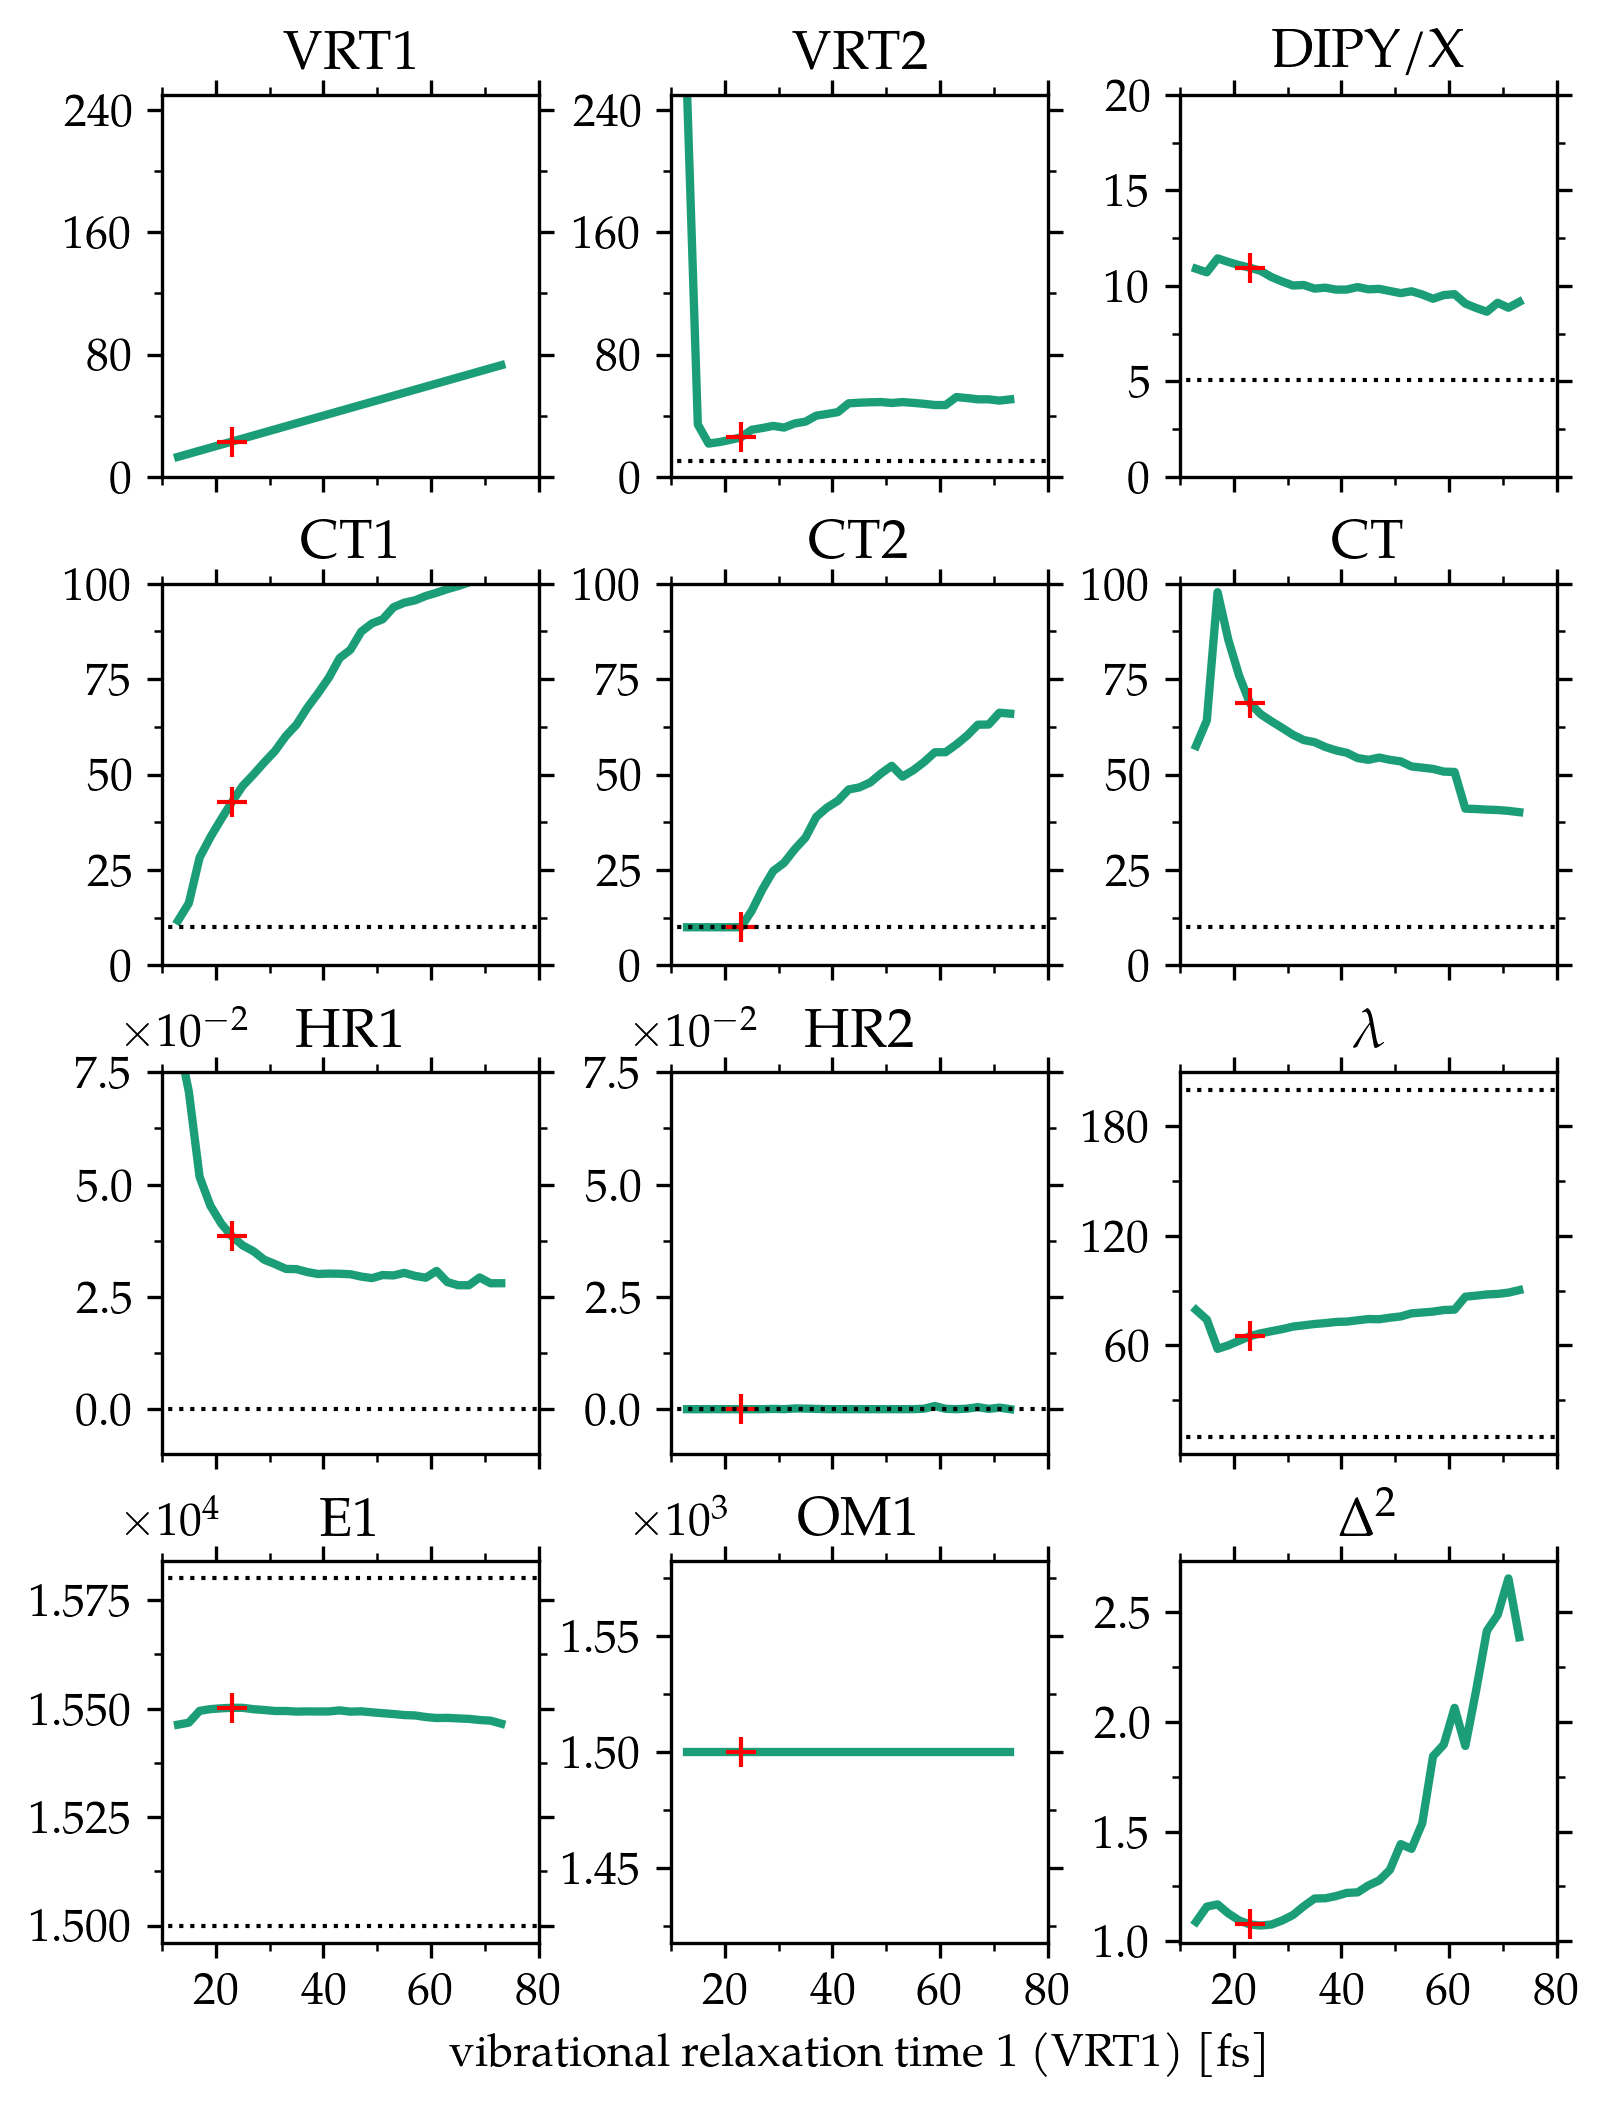

In [34]:
from matplotlib import cm
from spectre.matplotlib_latex import plt_latex, format_ticks

plt_latex()
clm = cm.get_cmap('viridis', len(files))

fig, grid = plt.subplots(4, 3, figsize=(6,8), dpi=300, sharex=True, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.28, wspace=0.35)

labels = list()

tt11 = list()
tt12 = list()
dipyx = list()
ct11 = list()
ct12 = list()
ct = list()
lamb = list()
hr11 = list()
hr12 = list()
e1 = list()
de = list()
om1 = list()
alpha = list()

for i, f in enumerate(sfiles[:]):
    filepath = os.path.join(path, f)
    optpars = spectre.utils.loadjson(filepath)
    datapath = filepath.replace('.json', '.npy')
    
    if os.path.isfile(datapath):
        data = np.load(datapath)
    else:
        syst, ta = spectre.full.init_system(optpars)
        spec = abss.calculate_abs_spectrum(syst, ta, optpars)
        spec.normalize()
        
        with qr.energy_units('1/cm'):
            data = np.vstack([spec.axis.data, spec.data])
            np.save(datapath, data)

    lab = f.split('.')[0].split('_')[2]
    labels.append(float(lab))

    tt11.append(optpars['scaled_OB_CF_vib_11']['target_time'])
    tt12.append(optpars['scaled_OB_CF_vib_12']['target_time'])
    dipyx.append(4.5**2 / optpars['dipx'][0]**2)
    ct11.append(optpars['scaled_OB_CF_vib_11']['cortime'])
    ct12.append(optpars['scaled_OB_CF_vib_12']['cortime'])
    ct.append(optpars['spectral_density_el']['cortime'])
    lamb.append(optpars['spectral_density_el']['reorg'])
    hr11.append(optpars['hr1'][0])
    hr12.append(optpars['hr1'][1])
    e1.append(optpars['energies'][1])
    de.append(optpars['energies'][2] - optpars['energies'][1])
    om1.append(optpars['omega'][0])
    alpha.append(optpars['dia_alpha1'])

ii = [i for i,x in enumerate(labels) if x == 23][0]

### Line & marker parameters
pars = dict(linewidth=2, )
mpars = dict(marker='+', c='r', markersize=7)
lpars = dict(linewidth=1, linestyle='dotted', c='k')


## TT11
grid[0,0].plot(labels, tt11, **pars)
grid[0,0].plot(labels[ii], tt11[ii], **mpars)
grid[0,0].set_title('VRT1')

## TT12
grid[0,1].plot(labels, tt12, **pars)
grid[0,1].plot(labels[ii], tt12[ii], **mpars)
grid[0,1].set_title('VRT2')
draw_line(grid[0,1], labels, 10, 300, **lpars)
          
## DIP Y/X
grid[0,2].plot(labels, dipyx, **pars)
grid[0,2].plot(labels[ii], dipyx[ii], **mpars)
grid[0,2].set_title('DIPY/X')
draw_line(grid[0,2], labels, 4.5**2 / 0.2**2, 4.5**2 / 2**2, **lpars)

## CT11
grid[1,0].plot(labels, ct11, **pars)
grid[1,0].plot(labels[ii], ct11[ii], **mpars)
grid[1,0].set_title('CT1')
draw_line(grid[1,0], labels, 10, 200, **lpars)

## CT12
grid[1,1].plot(labels, ct12, **pars)
grid[1,1].plot(labels[ii], ct12[ii], **mpars)
grid[1,1].set_title('CT2')
draw_line(grid[1,1], labels, 10, 200, **lpars)

## CT
grid[1,2].plot(labels, ct, **pars)
grid[1,2].plot(labels[ii], ct[ii], **mpars)
grid[1,2].set_title('CT')
draw_line(grid[1,2], labels, 10, 200, **lpars)

## HR11
grid[2,0].plot(labels, hr11, **pars)
grid[2,0].plot(labels[ii], hr11[ii], **mpars)
grid[2,0].set_title('HR1')
draw_line(grid[2,0], labels, 0.00001, 0.4, **lpars)

## HR12
grid[2,1].plot(labels, hr12, **pars)
grid[2,1].plot(labels[ii], hr12[ii], **mpars)
grid[2,1].set_title('HR2')
draw_line(grid[2,1], labels, 0.00001, 0.4, **lpars)

## lambda
grid[2,2].plot(labels, lamb, **pars)
grid[2,2].plot(labels[ii], lamb[ii], **mpars)
grid[2,2].set_title(r'$\lambda$')
draw_line(grid[2,2], labels, 10, 200, **lpars)

## e1
grid[3,0].plot(labels, e1, **pars)
grid[3,0].plot(labels[ii], e1[ii], **mpars)
grid[3,0].set_title('E1')
draw_line(grid[3,0], labels, 15000, 15800, **lpars)

## omega
grid[3,1].plot(labels, om1, **pars)
grid[3,1].plot(labels[ii], om1[ii], **mpars)
grid[3,1].set_title('OM1')
#draw_line(grid[3,1], labels, 0.00001, 0.4, **lpars)

# ## alpha
# grid[3,2].plot(labels, alpha, **pars)
# grid[3,2].plot(labels[ii], alpha[ii], **mpars)
# grid[3,2].set_title(r'$\alpha$')
# #draw_line(grid[3,2], labels, 0.00001, 0.4, **lpars)

## alpha
delta = (zax**2).sum(axis=1)
grid[3,2].plot(labels, delta, **pars)
grid[3,2].plot(labels[ii], delta[ii], **mpars)
grid[3,2].set_title(r'$\Delta^2$')
#draw_line(grid[3,2], labels, 0.00001, 0.4, **lpars)
    


grid[0,0].set_ylim(0,250)
grid[0,1].sharey(grid[0,0])
# grid[0,1].set_ylim(0,250)

grid[1,0].set_ylim(0,100)
grid[1,1].sharey(grid[1,0])
grid[1,2].sharey(grid[1,0])
# grid[1,1].set_ylim(0,100)
# grid[1,2].set_ylim(0,100)

grid[2,0].set_ylim(-0.01, 0.075)
grid[2,1].sharey(grid[2,0])
# grid[2,1].set_ylim(-0.01, 0.075)

grid[0,0].set_xlim(10, 80)

grid[0,2].set_ylim(0,20)

#plt.xlim(14000, 20000)
#plt.ylim(-0.1, 1.1)
#plt.legend(frameon=False)

#sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(labels[0], labels[-1]))
#cbar = plt.colorbar(sm, orientation='horizontal')
#cbar.set_ticklabels(labs)

### TICKS
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator

for g in grid[:].flatten():
    pars = dict(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                bottom=True,           top=True,      left=True,      right=True,)
    #minor_pars = dict(bottom=True,           top=True,      left=True,      right=True)
    g.tick_params(which='both', **pars)
    #g.minor_tick_params(**minor_pars)
    
    g.xaxis.set_major_locator(MultipleLocator(20))
    g.xaxis.set_major_formatter('{x:.0f}')
    g.xaxis.set_minor_locator(MultipleLocator(10))
    g.yaxis.set_major_locator(MaxNLocator(nbins=4))
    g.yaxis.set_minor_locator(AutoMinorLocator(2))
    g.ticklabel_format(style='sci', axis='y', scilimits=(-1,3), useOffset=True)

    g.get_yaxis().set_offset_position("left")
    g.get_yaxis().OFFSETTEXTPAD = 7
    #g.get_yaxis().get_offset_text().set_position((-0.032,0))
    g.get_yaxis().get_offset_text().set_position((-0.097,0))

for g in grid[-1].flatten():
    pars = dict(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
    g.tick_params(which='both', **pars)

# plt.locator_params(axis='x', nbins=4)
# plt.locator_params(axis='y', nbins=4)
#fig.tight_layout()

grid[3,1].set_xlabel('vibrational relaxation time 1 (VRT1) [fs]')

# (2.) - step 1

In [11]:
path = 'C:/Users/micha/Documents/Studium/MScThesis/data-meta/E-scanopt-ether02-1mode/results_E-ether02-1mode-s1-P-11010_scanopt_01_2023-07-10_10-27-53'

In [12]:
files = [file for file in os.listdir(path) if file.endswith('.json') and file.startswith('opt')]
sfiles = sorted(files, key=lambda s: float(s.split('.')[0].split('_')[2]))

C:\Users\micha\AppData\Local\Temp\ipykernel_48068\4220604495.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))


Reorg: 1056.82223003
Reorg: 28.1819261342
System init: 5.10s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.4s finished


Tensor calculation: 2.31s
Spectrum calculation (CPU): 7.68s
Reorg: 939.397537808
Reorg: 28.1819261342
System init: 5.05s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.31s
Spectrum calculation (CPU): 7.14s
Reorg: 845.457784064
Reorg: 28.1819261342
System init: 5.02s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.3s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 7.48s
Reorg: 787.097682844
Reorg: 28.1819261343
System init: 4.96s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 7.22s
Reorg: 744.863379536
Reorg: 28.1819261342
System init: 4.98s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 7.26s
Reorg: 736.817755285
Reorg: 28.1819261352
System init: 5.02s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 7.32s
Reorg: 716.365552239
Reorg: 28.1819261345
System init: 4.98s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 7.27s
Reorg: 854.068159331
Reorg: 241.817908807
System init: 5.04s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 7.10s
Reorg: 1098.35777387
Reorg: 383.597474099
System init: 4.95s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.2s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.42s
Reorg: 1267.54409473
Reorg: 390.070887967
System init: 4.99s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 7.27s
Reorg: 1319.67821562
Reorg: 381.123459688
System init: 5.03s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.25s
Spectrum calculation (CPU): 7.30s
Reorg: 1342.66709464
Reorg: 372.546311243
System init: 5.13s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.3s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.49s
Reorg: 1364.87397127
Reorg: 361.502997454
System init: 5.07s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.3s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 7.50s
Reorg: 1381.80366433
Reorg: 350.799239745
System init: 5.01s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.36s
Spectrum calculation (CPU): 7.28s
Reorg: 1387.29689808
Reorg: 342.802757206
System init: 4.99s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.32s
Spectrum calculation (CPU): 7.21s
Reorg: 1407.18223822
Reorg: 328.332208239
System init: 5.01s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.30s
Spectrum calculation (CPU): 7.21s
Reorg: 1410.26168719
Reorg: 319.556747198
System init: 5.04s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.32s
Spectrum calculation (CPU): 7.17s
Reorg: 1404.68288726
Reorg: 313.116710731
System init: 5.00s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 7.17s
Reorg: 1383.71210153
Reorg: 360.693111519
System init: 5.02s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.30s
Spectrum calculation (CPU): 6.99s
Reorg: 1386.94355644
Reorg: 436.325566604
System init: 5.01s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 7.02s
Reorg: 1381.53018665
Reorg: 471.738837467
System init: 5.04s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.17s
Reorg: 1376.22629465
Reorg: 524.013808498
System init: 5.01s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 7.20s
Reorg: 1378.52908017
Reorg: 554.893671249
System init: 5.01s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.13s
Reorg: 1376.09946181
Reorg: 578.247260096
System init: 5.02s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.6s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 6.81s
Reorg: 1359.73310092
Reorg: 628.419283857
System init: 5.05s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.34s
Reorg: 1357.76589976
Reorg: 619.610997974
System init: 5.04s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 7.11s
Reorg: 1340.54939966
Reorg: 674.927084755
System init: 5.08s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.34s
Spectrum calculation (CPU): 7.13s
Reorg: 1342.0736262
Reorg: 741.338198199
System init: 5.04s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 7.26s
Reorg: 1327.3104068
Reorg: 770.786707757
System init: 5.02s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.19s
Reorg: 1319.87494284
Reorg: 796.170360488
System init: 5.03s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.31s
Spectrum calculation (CPU): 7.19s
Reorg: 1318.07860617
Reorg: 810.571356209
System init: 5.02s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 7.17s
Reorg: 1288.52317864
Reorg: 810.578334289
System init: 5.07s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 6.92s
Reorg: 1315.04163164
Reorg: 831.042905171
System init: 5.03s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 7.17s
Reorg: 1328.88413327
Reorg: 853.740531191
System init: 5.09s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.34s
Spectrum calculation (CPU): 7.04s
Reorg: 1304.79267446
Reorg: 853.208351608
System init: 5.03s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 6.95s
Reorg: 1320.81978082
Reorg: 806.40354288
System init: 5.07s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 7.34s
Reorg: 1311.30075048
Reorg: 804.230293161
System init: 5.05s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.17s
Reorg: 1301.40838639
Reorg: 804.612329486
System init: 5.19s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.42s
Spectrum calculation (CPU): 7.27s
Reorg: 1294.5453507
Reorg: 806.916002887
System init: 4.96s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.2s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 7.46s
Reorg: 1282.56305441
Reorg: 803.667275464
System init: 4.99s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.2s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 7.41s
Reorg: 1270.83888334
Reorg: 806.874862901
System init: 4.98s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 7.17s
Reorg: 1267.0759686
Reorg: 809.646932012
System init: 4.99s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 7.24s
Reorg: 1253.28213709
Reorg: 808.52964292
System init: 5.00s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.27s
Spectrum calculation (CPU): 7.11s
Reorg: 1244.14684733
Reorg: 810.814977817
System init: 5.01s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.10s
Reorg: 1280.28172527
Reorg: 838.917410347
System init: 5.04s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 7.20s
Reorg: 1272.832434
Reorg: 828.227309847
System init: 4.97s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 7.18s
Reorg: 1271.34814068
Reorg: 829.704333971
System init: 5.02s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.08s
Reorg: 1260.38875309
Reorg: 829.268706891
System init: 5.02s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 7.07s
Reorg: 1253.15094376
Reorg: 830.04526396
System init: 5.04s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 7.17s
Reorg: 1239.66441423
Reorg: 828.363096468
System init: 5.11s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 7.21s
Reorg: 1224.6883178
Reorg: 828.582319618
System init: 5.09s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.33s
Spectrum calculation (CPU): 7.02s
Reorg: 1234.99023521
Reorg: 814.975435773
System init: 5.05s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.30s
Spectrum calculation (CPU): 7.23s
Reorg: 1217.79678314
Reorg: 812.804509503
System init: 5.06s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 6.99s
Reorg: 1208.85571008
Reorg: 808.872610988
System init: 5.10s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 7.20s
Reorg: 1191.53478977
Reorg: 809.120579417
System init: 5.16s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.28s
Spectrum calculation (CPU): 6.94s
Reorg: 1191.84529617
Reorg: 818.5436843
System init: 5.07s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.31s
Spectrum calculation (CPU): 7.10s
Reorg: 1177.68494467
Reorg: 816.384890363
System init: 5.05s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 7.11s
Reorg: 1167.7935605
Reorg: 814.795789587
System init: 5.07s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.1s finished


Tensor calculation: 2.30s
Spectrum calculation (CPU): 7.28s
Reorg: 1156.1056719
Reorg: 813.480760297
System init: 5.09s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 7.01s
Reorg: 1173.97724082
Reorg: 830.003450501
System init: 5.05s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 7.07s
Reorg: 1156.90945207
Reorg: 830.014581504
System init: 5.11s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 7.18s
Reorg: 1146.38303167
Reorg: 829.892639749
System init: 5.08s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.41s
Spectrum calculation (CPU): 7.11s
Reorg: 1137.36576901
Reorg: 829.72639874
System init: 5.03s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.8s finished


Tensor calculation: 2.26s
Spectrum calculation (CPU): 7.01s
Reorg: 1126.60988881
Reorg: 831.162929224
System init: 4.99s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.9s finished


Tensor calculation: 2.29s
Spectrum calculation (CPU): 7.13s
Reorg: 1114.99449363
Reorg: 831.945623433
System init: 4.97s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    6.7s finished


Tensor calculation: 2.24s
Spectrum calculation (CPU): 6.95s
Reorg: 1108.01371249
Reorg: 832.05793151
System init: 4.96s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.0s finished
C:\Users\micha\AppData\Local\Temp\ipykernel_48068\4220604495.py:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='horizontal')


Tensor calculation: 2.31s
Spectrum calculation (CPU): 7.20s


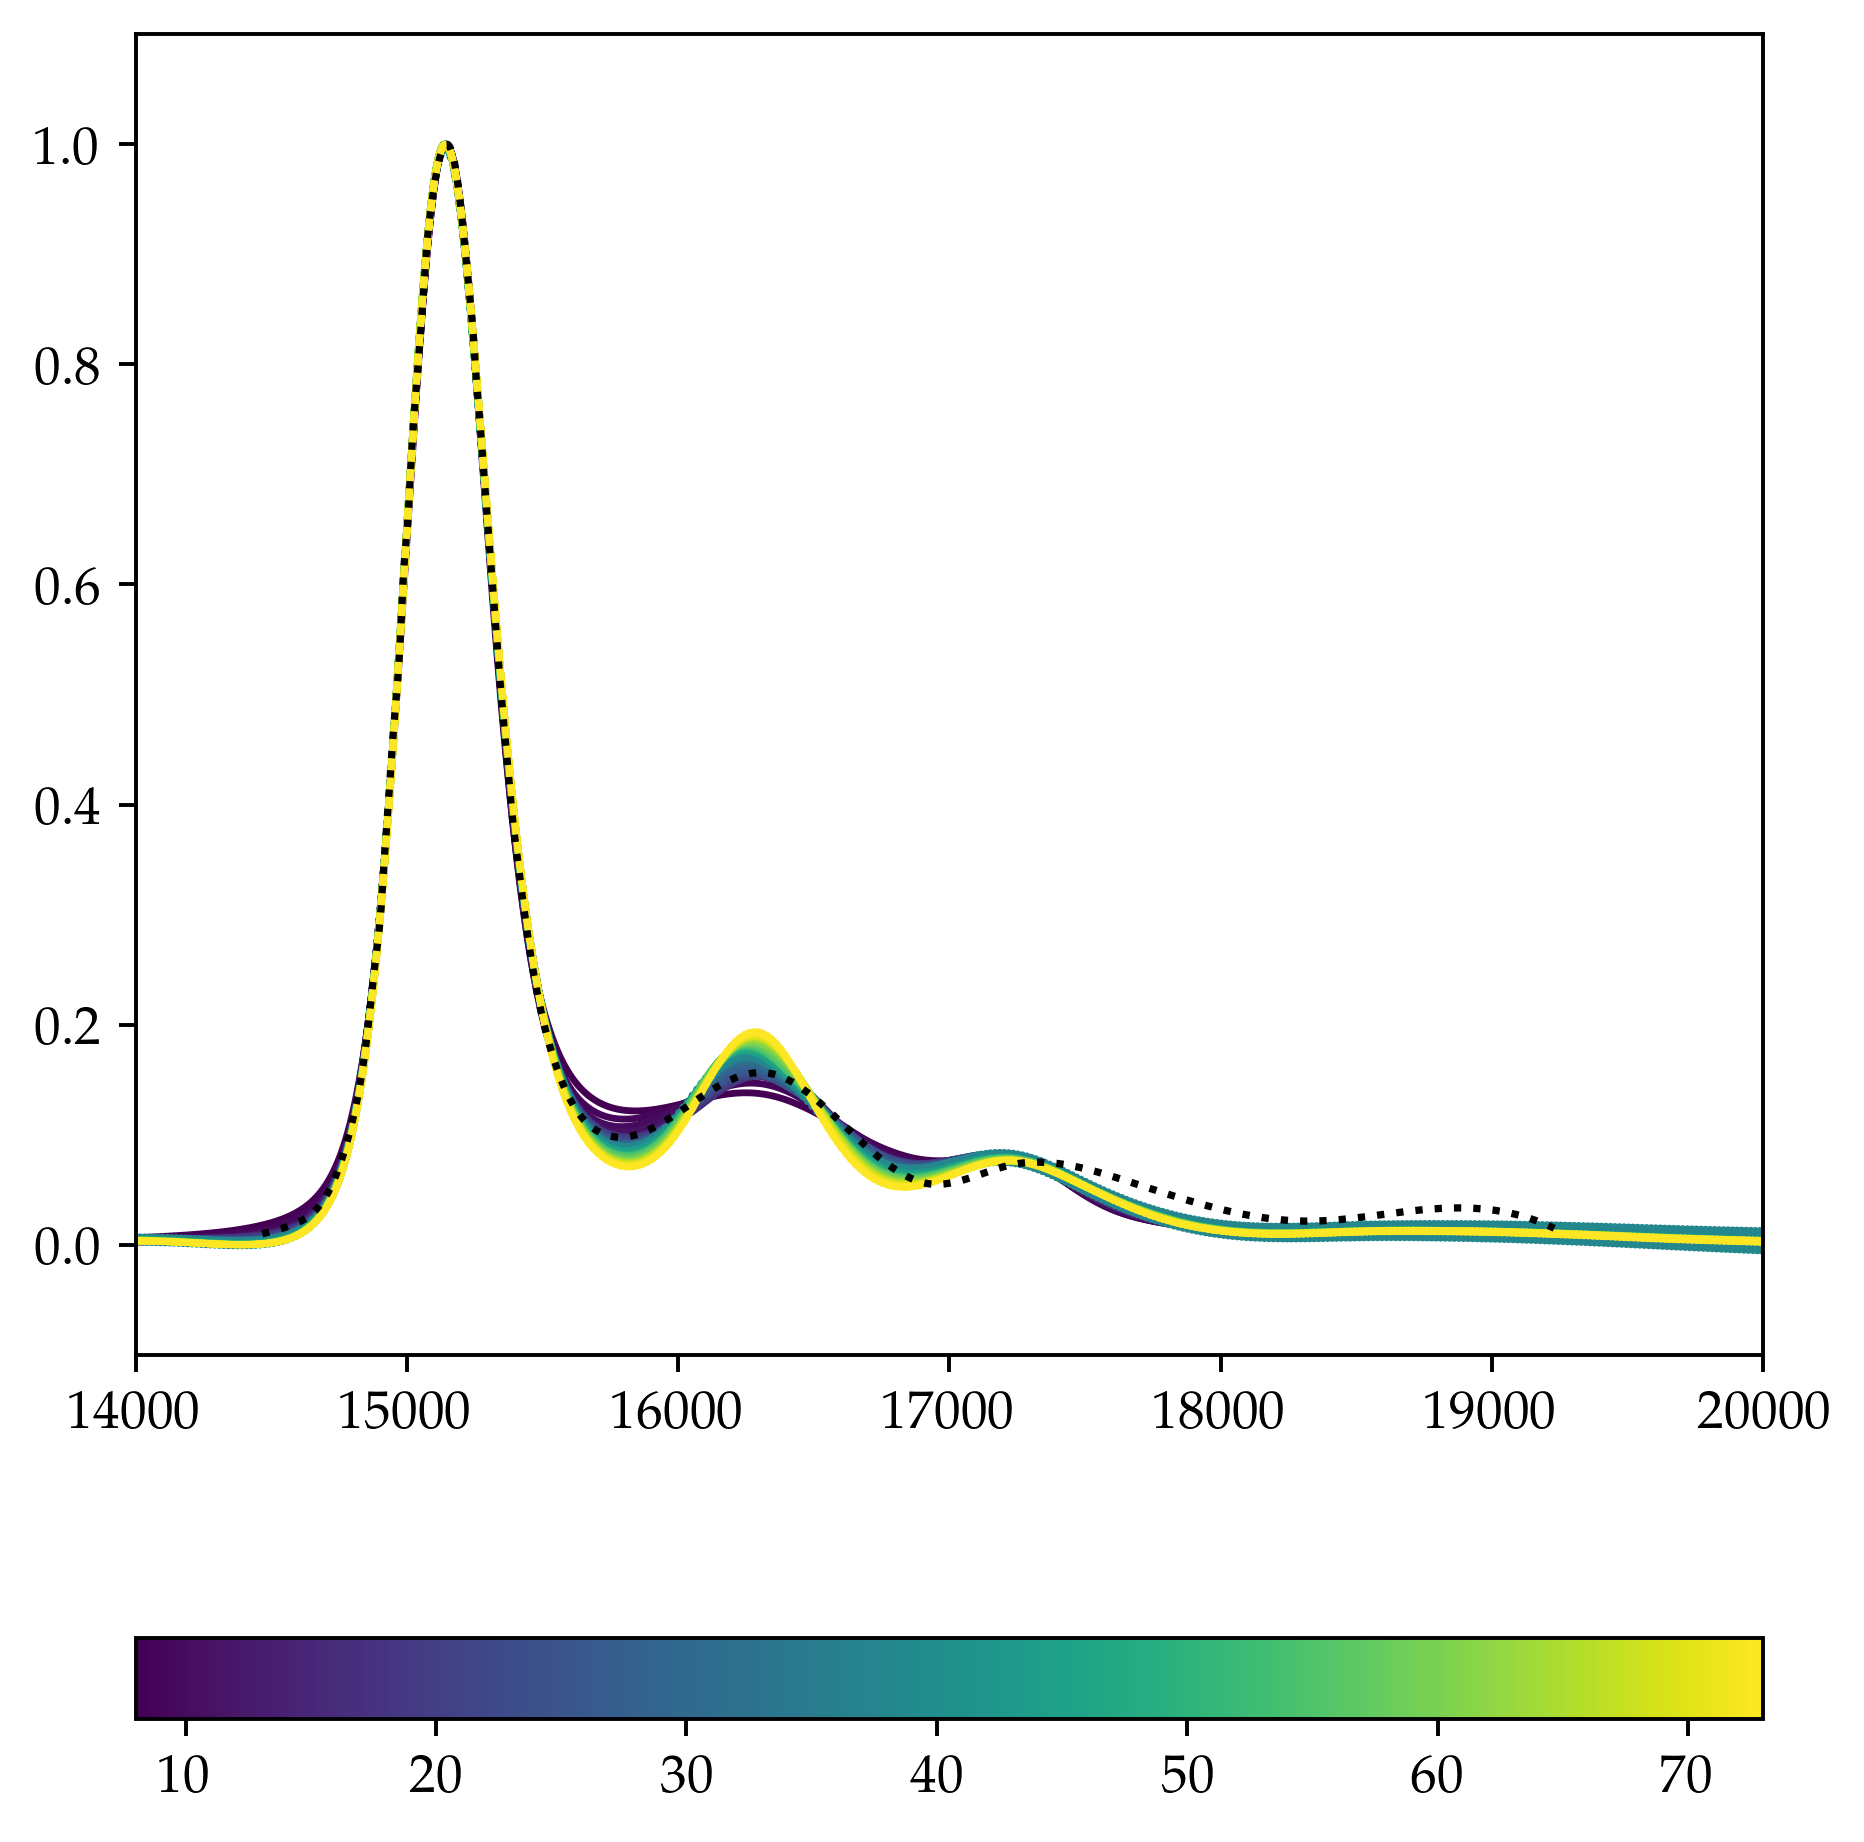

In [13]:
from matplotlib import cm
clm = cm.get_cmap('viridis', len(files))

fig, ax = plt.subplots(figsize=(6,7), dpi= 350)
labels = list()

for i, f in enumerate(sfiles[:]):
    filepath = os.path.join(path, f)
    optpars = spectre.utils.loadjson(filepath)
    datapath = filepath.replace('.json', '.npy')
    
    if os.path.isfile(datapath):
        data = np.load(datapath)
    else:
        syst, ta = spectre.full.init_system(optpars)
        spec = abss.calculate_abs_spectrum(syst, ta, optpars)
        spec.normalize()
        
        with qr.energy_units('1/cm'):
            data = np.vstack([spec.axis.data, spec.data])
            np.save(datapath, data)

    lab = f.split('.')[0].split('_')[2]
    plt.plot(data[0], data[1], label=lab, linewidth=1.4, color=clm(i))
    labels.append(lab)

plt.xlim(14000, 20000)
plt.ylim(-0.1, 1.1)
#plt.legend(frameon=False)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(labels[0], labels[-1]))
cbar = plt.colorbar(sm, orientation='horizontal')
#cbar.set_ticklabels(labs)

abss.plot_ref(2, plot_to=ax, color='k', linestyle = 'dotted')

C:\Users\micha\AppData\Local\Temp\ipykernel_48068\1249547784.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))
C:\Users\micha\AppData\Local\Temp\ipykernel_48068\1249547784.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[3])
 45%|██████████████████████████████████████▋                                              | 30/66 [00:15<00:28,  1.27it/s]C:\Users\micha\miniconda3\envs\py310-maya-1\lib\site-packages\scipy\interpolate\_fitpack2.py:298: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation 

Text(0, 0.5, 'residuum')

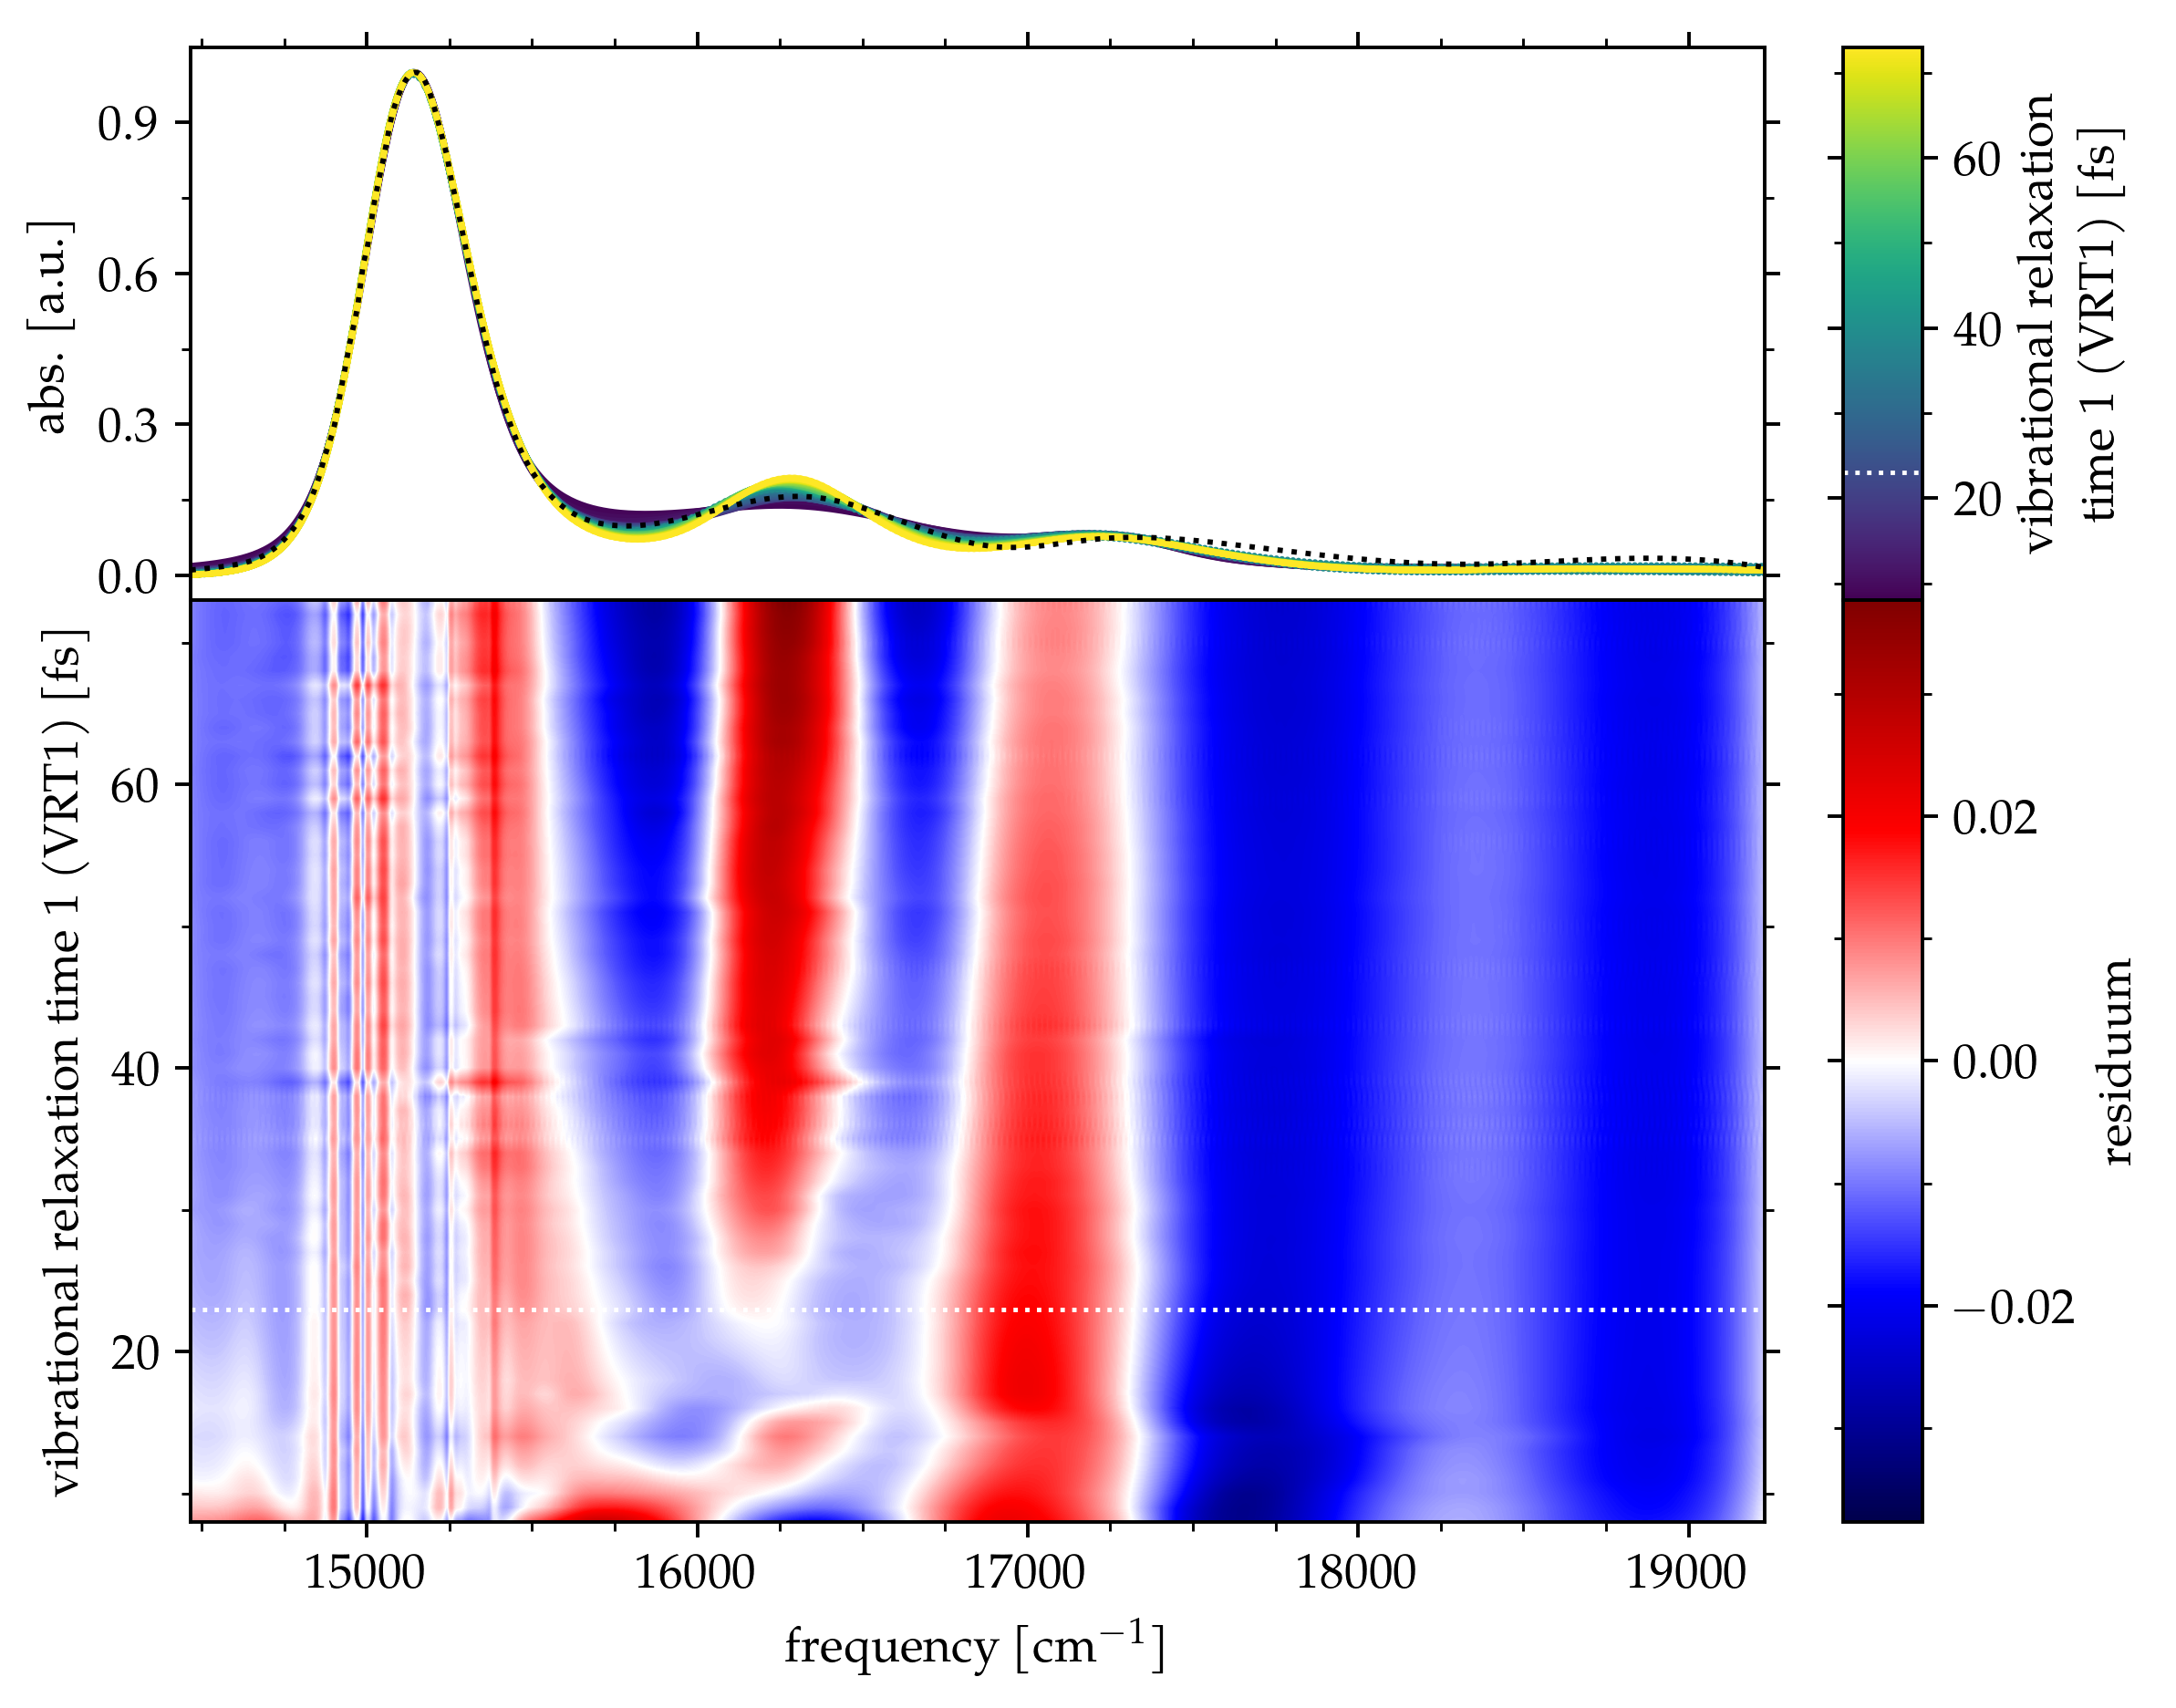

In [14]:
from matplotlib import cm
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
from matplotlib import gridspec

spline_s=0.0002
spline_k=3

clm = cm.get_cmap('viridis', len(files))

refdata = abss.plot_ref(2, return_data='data', plot=False)
refx, refy = refdata

fig, ax = plt.subplots(num=None, figsize=(7,6), dpi=350, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 0.05, 0.05), height_ratios=(0.6, 1), figure=fig) 
#ax3 = plt.subplot(gs[3])
ax0 = plt.subplot(gs[3])
ax1 = plt.subplot(gs[0], sharex = ax0)
ax4 = plt.subplot(gs[5])
ax2 = plt.subplot(gs[2])
plt.subplots_adjust(hspace=0, wspace=0)

####################
#   ax1   #  # ax2 #
####################
#   ax0   #  # ax4 #
####################

all_data_filename = 'all_data.npy'
all_data_path = os.path.join(path, all_data_filename)

if os.path.isfile(all_data_path) and True:
    x, y, zdata = np.load(all_data_path)

    for i, z in enumerate(zdata):
        ax1.plot(x[i], z, linewidth=1.4, color=clm(i))
    
    zax = zdata - refy

else:
    labels = list()
    zax = None
    zdata = None
    i = 0

    for f in tqdm(sfiles[:]):
        i += 1
        filepath = os.path.join(path, f)
        optpars = spectre.utils.loadjson(filepath)
        datapath = filepath.replace('.json', '.npy')
        
        if os.path.isfile(datapath):
            data = np.load(datapath)
        else:
            syst, ta = spectre.full.init_system(optpars)
            spec = abss.calculate_abs_spectrum(syst, ta, optpars)
            spec.normalize()
            
            with qr.energy_units('1/cm'):
                data = np.vstack([spec.axis.data, spec.data])
                np.save(datapath, data)
    
        lab = f.split('.')[0].split('_')[2]
        spline = UnivariateSpline(*data, k=spline_k, s=spline_s)
        ydat = spline(refx) - refy
        
        if zax is None:
            zax = ydat
            zdata = spline(refx)
        else:
            zax = np.vstack([zax, ydat])
            zdata = np.vstack([zdata, spline(refx)])
        
        ax1.plot(data[0], data[1], label=lab, linewidth=1.4, color=clm(i))
        labels.append(float(lab))

    yax = np.array(labels)
    xax = refx
    x, y = np.meshgrid(xax, yax)
    np.save(all_data_path, np.array([x, y, zdata]))

maximum = np.abs(zax).max()

cf = ax0.contourf(x, y, zax, 500, cmap="seismic", vmax=maximum, vmin=-maximum)

#CS = ax0.contour(x, y, zax, 5)
#ax0.clabel(CS, inline=True, fontsize=10)

sm = plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(-maximum, maximum))
cbar = plt.colorbar(sm, cax=ax4, orientation='vertical')

sm2 = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(y[0,0], y[-1,0]))
cbar2 = plt.colorbar(sm2, cax=ax2, orientation='vertical')

ax0.plot([x[0,0], x[0,-1]], [23,23], linewidth=1, linestyle='dotted', c='w')
ax2.plot([0, 1], [23,23], linewidth=1, linestyle='dotted', c='w')

abss.plot_ref(2, plot_to=ax1, linestyle='dotted', c='k', linewidth=1.2)

from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator

for g in [ax0, ax1, ax2, ax4]:
    pars = dict(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                bottom=True,           top=True,      left=True,      right=True,)
    g.tick_params(which='both', **pars)
    
    #g.xaxis.set_major_locator(MultipleLocator(20))
    #g.xaxis.set_major_formatter('{x:.0f}')
    #g.xaxis.set_minor_locator(MultipleLocator(10))
    g.yaxis.set_major_locator(MaxNLocator(nbins=4))
    g.yaxis.set_minor_locator(AutoMinorLocator(2))
    g.xaxis.set_minor_locator(AutoMinorLocator(4))
    #g.ticklabel_format(style='sci', axis='y', scilimits=(-1,3), useOffset=True)

    #g.get_yaxis().set_offset_position("left")
    #g.get_yaxis().OFFSETTEXTPAD = 7
    #g.get_yaxis().get_offset_text().set_position((-0.097,0))

ax4.yaxis.set_major_locator(MaxNLocator(nbins=5))

ax0.tick_params(which='both', labelbottom=True, labelleft=True)
ax1.tick_params(which='both', bottom=False)
ax2.tick_params(which='both', labelleft=False, labelright=True)
ax4.tick_params(which='both', labelleft=False, labelright=True)

ax0.set_xlim(x[0,0], x[0,-1])
ax1.set_ylim(-0.05, 1.05)

ax0.set_xlabel(r'frequency [cm$^{-1}$]')
ax0.set_ylabel(r'vibrational relaxation time 1 (VRT1) [fs]')
ax1.set_ylabel(r'abs. [a.u.]')
ax2.set_ylabel(r'\parbox{40mm}{\centering vibrational relaxation time 1 (VRT1) [fs]}')
ax4.set_ylabel(r'residuum')

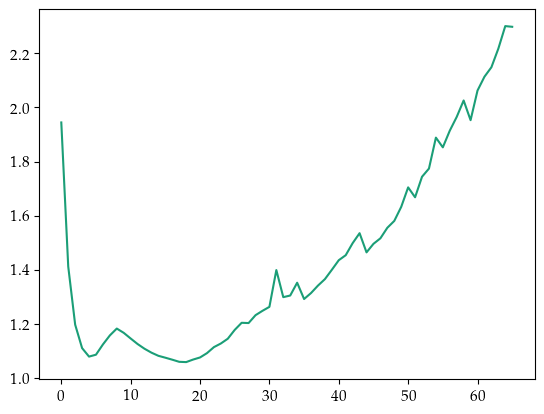

In [15]:
plt.plot((zax**2).sum(axis=1))

In [14]:
def draw_line(plot_to, xaxis, *vals, **pars):
    for val in vals:
        plot_to.plot([xaxis[0]-10, xaxis[-1]+10], [val, val], **pars)

C:\Users\micha\AppData\Local\Temp\ipykernel_14232\1409679701.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))


Text(0.5, 0, 'targeted relaxation time 1 ($\\uptau_{T,1}$) [fs]')

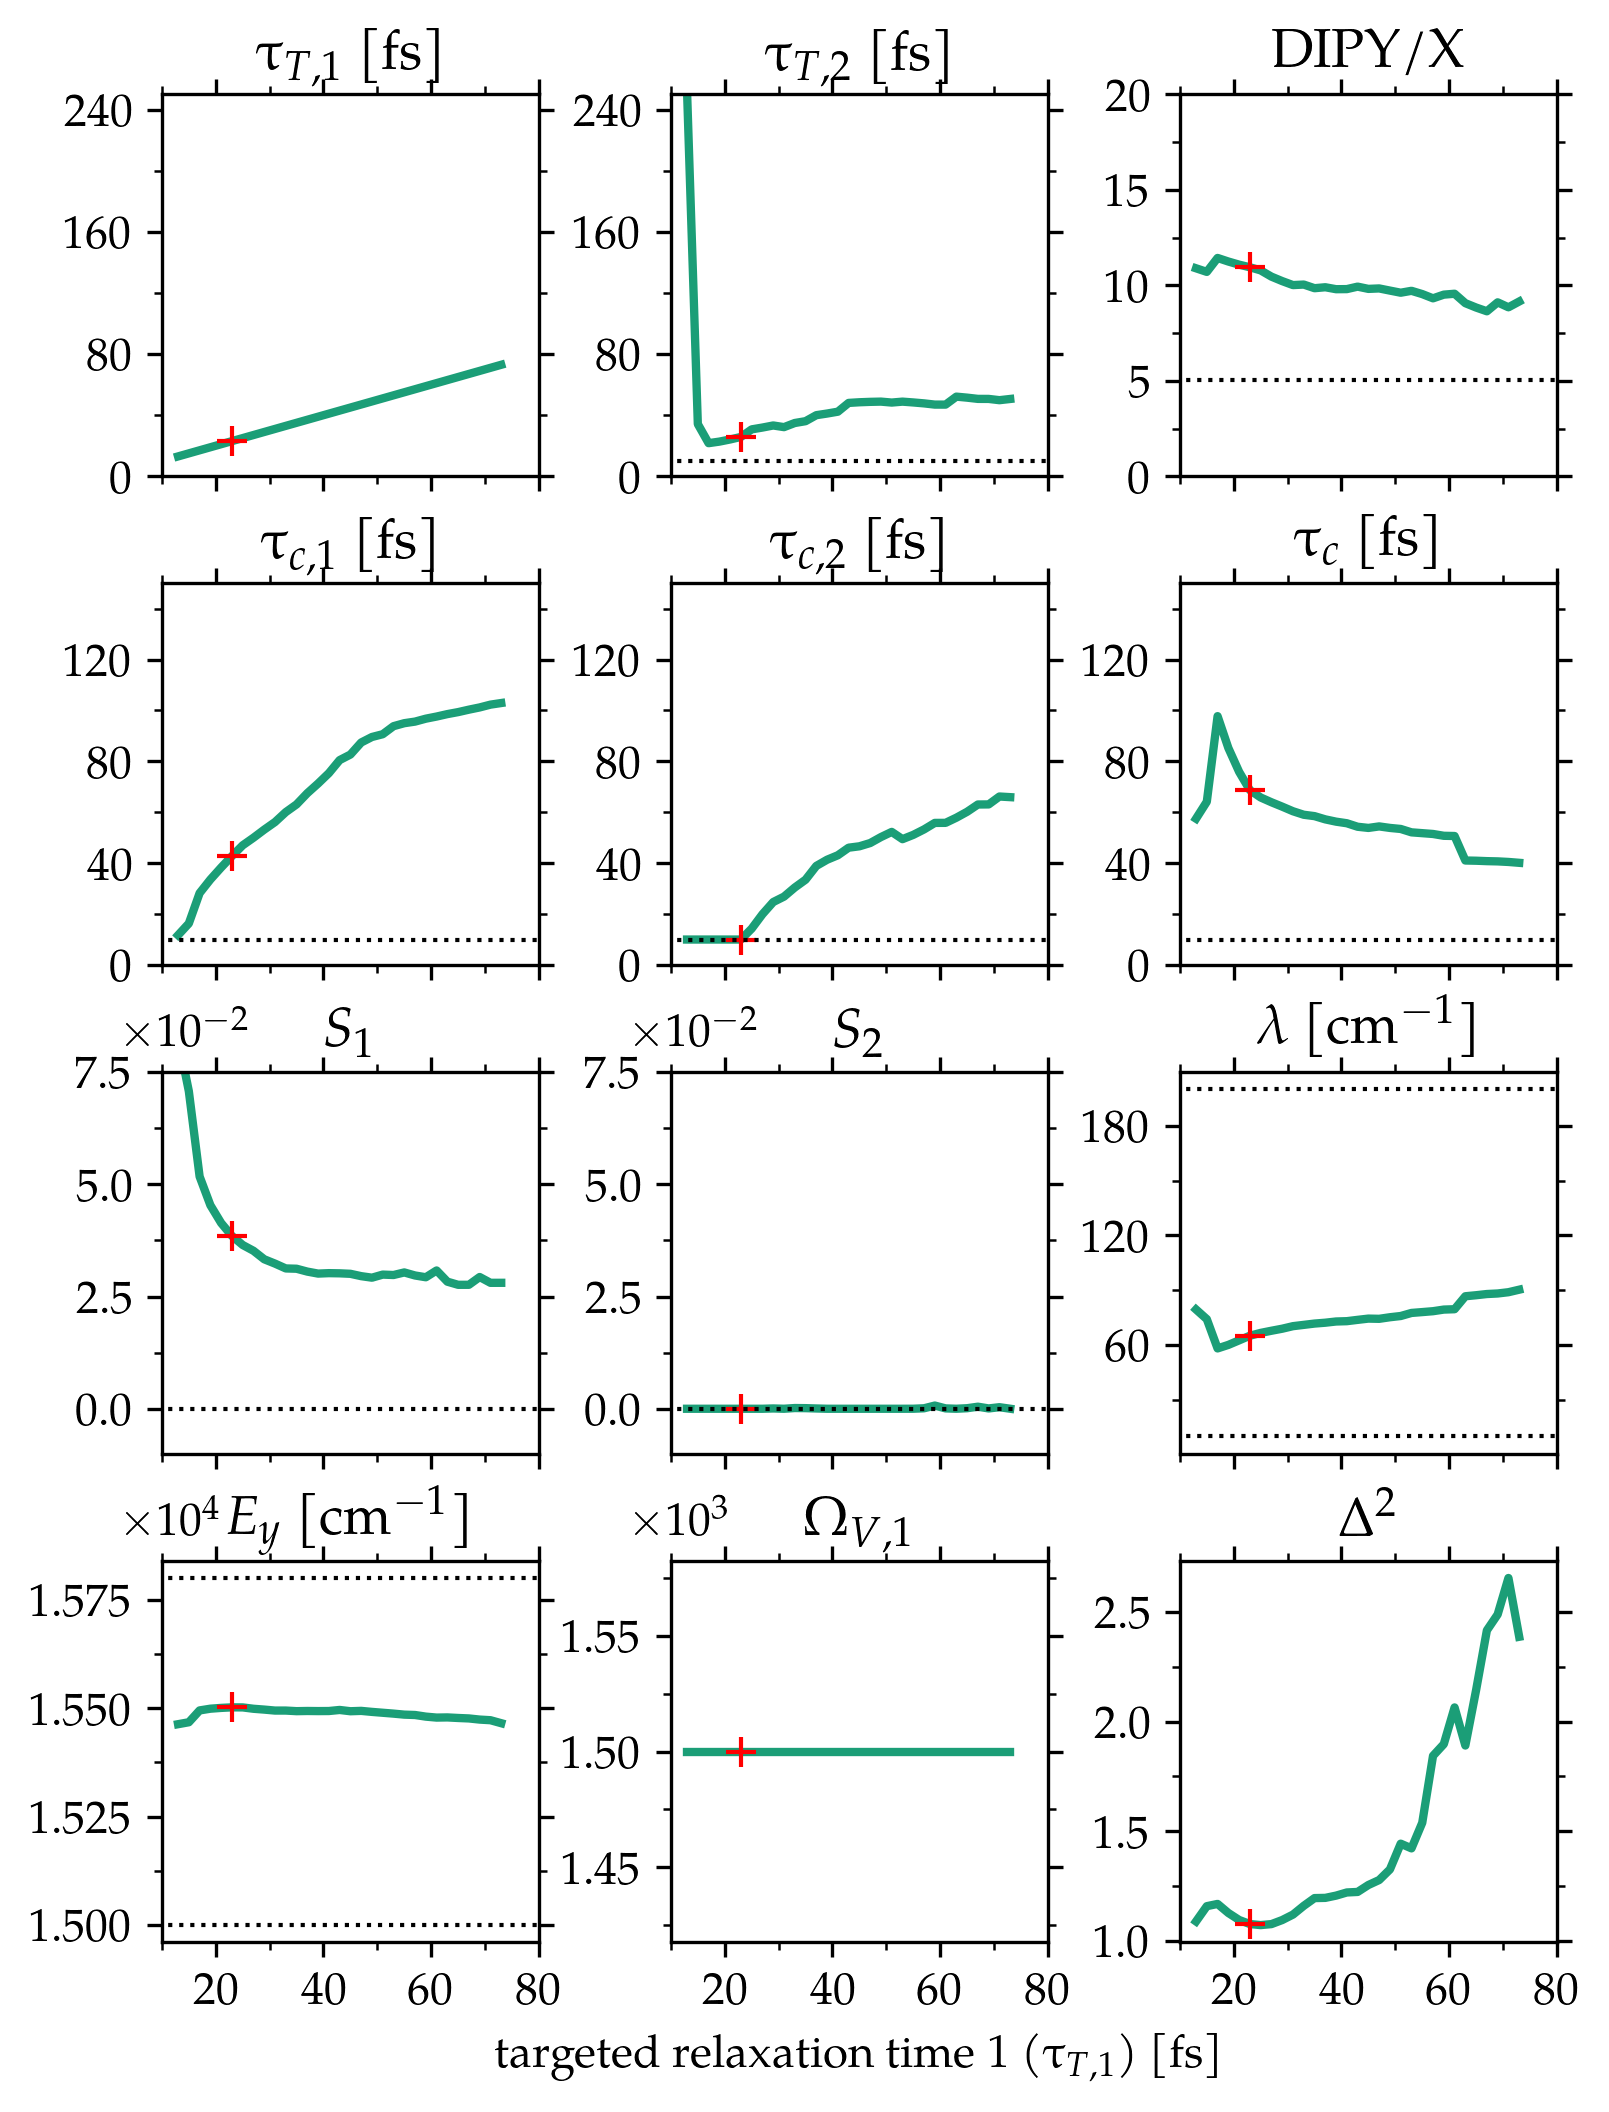

In [18]:
from matplotlib import cm
from spectre.matplotlib_latex import plt_latex, format_ticks

plt_latex()
clm = cm.get_cmap('viridis', len(files))

fig, grid = plt.subplots(4, 3, figsize=(6,8), dpi=300, sharex=True, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.28, wspace=0.35)

labels = list()

tt11 = list()
tt12 = list()
dipyx = list()
ct11 = list()
ct12 = list()
ct = list()
lamb = list()
hr11 = list()
hr12 = list()
e1 = list()
de = list()
om1 = list()
alpha = list()

for i, f in enumerate(sfiles[:]):
    filepath = os.path.join(path, f)
    optpars = spectre.utils.loadjson(filepath)
    datapath = filepath.replace('.json', '.npy')
    
    if os.path.isfile(datapath):
        data = np.load(datapath)
    else:
        syst, ta = spectre.full.init_system(optpars)
        spec = abss.calculate_abs_spectrum(syst, ta, optpars)
        spec.normalize()
        
        with qr.energy_units('1/cm'):
            data = np.vstack([spec.axis.data, spec.data])
            np.save(datapath, data)

    lab = f.split('.')[0].split('_')[2]
    labels.append(float(lab))

    tt11.append(optpars['scaled_OB_CF_vib_11']['target_time'])
    tt12.append(optpars['scaled_OB_CF_vib_12']['target_time'])
    dipyx.append(4.5**2 / optpars['dipx'][0]**2)
    ct11.append(optpars['scaled_OB_CF_vib_11']['cortime'])
    ct12.append(optpars['scaled_OB_CF_vib_12']['cortime'])
    ct.append(optpars['spectral_density_el']['cortime'])
    lamb.append(optpars['spectral_density_el']['reorg'])
    hr11.append(optpars['hr1'][0])
    hr12.append(optpars['hr1'][1])
    e1.append(optpars['energies'][1])
    de.append(optpars['energies'][2] - optpars['energies'][1])
    om1.append(optpars['omega'][0])
    alpha.append(optpars['dia_alpha1'])

ii = [i for i,x in enumerate(labels) if x == 23][0]

### Line & marker parameters
pars = dict(linewidth=2, )
mpars = dict(marker='+', c='r', markersize=7)
lpars = dict(linewidth=1, linestyle='dotted', c='k')


## TT11
grid[0,0].plot(labels, tt11, **pars)
grid[0,0].plot(labels[ii], tt11[ii], **mpars)
grid[0,0].set_title(r'$\uptau_{T,1}$ [fs]')

## TT12
grid[0,1].plot(labels, tt12, **pars)
grid[0,1].plot(labels[ii], tt12[ii], **mpars)
grid[0,1].set_title(r'$\uptau_{T,2}$ [fs]')
draw_line(grid[0,1], labels, 10, 300, **lpars)
          
## DIP Y/X
grid[0,2].plot(labels, dipyx, **pars)
grid[0,2].plot(labels[ii], dipyx[ii], **mpars)
grid[0,2].set_title('DIPY/X')
draw_line(grid[0,2], labels, 4.5**2 / 0.2**2, 4.5**2 / 2**2, **lpars)

## CT11
grid[1,0].plot(labels, ct11, **pars)
grid[1,0].plot(labels[ii], ct11[ii], **mpars)
grid[1,0].set_title(r'$\uptau_{c,1}$ [fs]')
draw_line(grid[1,0], labels, 10, 200, **lpars)

## CT12
grid[1,1].plot(labels, ct12, **pars)
grid[1,1].plot(labels[ii], ct12[ii], **mpars)
grid[1,1].set_title(r'$\uptau_{c,2}$ [fs]')
draw_line(grid[1,1], labels, 10, 200, **lpars)

## CT
grid[1,2].plot(labels, ct, **pars)
grid[1,2].plot(labels[ii], ct[ii], **mpars)
grid[1,2].set_title(r'$\uptau_{c}$ [fs]')
draw_line(grid[1,2], labels, 10, 200, **lpars)

## HR11
grid[2,0].plot(labels, hr11, **pars)
grid[2,0].plot(labels[ii], hr11[ii], **mpars)
grid[2,0].set_title(r'$S_1$')
draw_line(grid[2,0], labels, 0.00001, 0.4, **lpars)

## HR12
grid[2,1].plot(labels, hr12, **pars)
grid[2,1].plot(labels[ii], hr12[ii], **mpars)
grid[2,1].set_title(r'$S_2$')
draw_line(grid[2,1], labels, 0.00001, 0.4, **lpars)

## lambda
grid[2,2].plot(labels, lamb, **pars)
grid[2,2].plot(labels[ii], lamb[ii], **mpars)
grid[2,2].set_title(r'$\lambda$ [cm$^{-1}$]')
draw_line(grid[2,2], labels, 10, 200, **lpars)

## e1
grid[3,0].plot(labels, e1, **pars)
grid[3,0].plot(labels[ii], e1[ii], **mpars)
grid[3,0].set_title(r'$E_y$ [cm$^{-1}$]')
draw_line(grid[3,0], labels, 15000, 15800, **lpars)

## omega
grid[3,1].plot(labels, om1, **pars)
grid[3,1].plot(labels[ii], om1[ii], **mpars)
grid[3,1].set_title(r'$\Omega_{V,1}$')
#draw_line(grid[3,1], labels, 0.00001, 0.4, **lpars)

# ## alpha
# grid[3,2].plot(labels, alpha, **pars)
# grid[3,2].plot(labels[ii], alpha[ii], **mpars)
# grid[3,2].set_title(r'$\alpha$')
# #draw_line(grid[3,2], labels, 0.00001, 0.4, **lpars)

## alpha
delta = (zax**2).sum(axis=1)
grid[3,2].plot(labels, delta, **pars)
grid[3,2].plot(labels[ii], delta[ii], **mpars)
grid[3,2].set_title(r'$\Delta^2$')
#draw_line(grid[3,2], labels, 0.00001, 0.4, **lpars)
    


grid[0,0].set_ylim(0,250)
grid[0,1].sharey(grid[0,0])
# grid[0,1].set_ylim(0,250)

grid[1,0].set_ylim(0,150)
grid[1,1].sharey(grid[1,0])
grid[1,2].sharey(grid[1,0])
# grid[1,1].set_ylim(0,100)
# grid[1,2].set_ylim(0,100)

grid[2,0].set_ylim(-0.01, 0.075)
grid[2,1].sharey(grid[2,0])
# grid[2,1].set_ylim(-0.01, 0.075)

grid[0,0].set_xlim(10, 80)

grid[0,2].set_ylim(0,20)

#plt.xlim(14000, 20000)
#plt.ylim(-0.1, 1.1)
#plt.legend(frameon=False)

#sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(labels[0], labels[-1]))
#cbar = plt.colorbar(sm, orientation='horizontal')
#cbar.set_ticklabels(labs)

### TICKS
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator

for g in grid[:].flatten():
    pars = dict(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                bottom=True,           top=True,      left=True,      right=True,)
    #minor_pars = dict(bottom=True,           top=True,      left=True,      right=True)
    g.tick_params(which='both', **pars)
    #g.minor_tick_params(**minor_pars)
    
    g.xaxis.set_major_locator(MultipleLocator(20))
    g.xaxis.set_major_formatter('{x:.0f}')
    g.xaxis.set_minor_locator(MultipleLocator(10))
    g.yaxis.set_major_locator(MaxNLocator(nbins=4))
    g.yaxis.set_minor_locator(AutoMinorLocator(2))
    g.ticklabel_format(style='sci', axis='y', scilimits=(-1,3), useOffset=True)

    g.get_yaxis().set_offset_position("left")
    g.get_yaxis().OFFSETTEXTPAD = 7
    #g.get_yaxis().get_offset_text().set_position((-0.032,0))
    g.get_yaxis().get_offset_text().set_position((-0.097,0))

for g in grid[-1].flatten():
    pars = dict(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
    g.tick_params(which='both', **pars)

# plt.locator_params(axis='x', nbins=4)
# plt.locator_params(axis='y', nbins=4)
#fig.tight_layout()

grid[3,1].set_xlabel(r'targeted relaxation time 1 ($\uptau_{T,1}$) [fs]')